# Clasificación de Sargazo

Notebook inicial para clasificar el nivel de sargazon en imágenes de la playa. Tu puedes dividir el conjunto de datos entre entrenamiento y validación.

In [28]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, transform
from PIL import Image
import os
import time
import copy

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms, utils
import torch.optim as optim
import sklearn
import sklearn.model_selection as skl
import seaborn as sn
%matplotlib inline
use_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)
print("Torch version: ", torch.__version__)
print("Torchvision version: ", torchvision.__version__)
!python --version

cuda:0
Torch version:  2.0.0
Torchvision version:  0.15.1
Python 3.10.10


In [29]:
# Directorio de la carpeta donde esta el dataset
img_folder = '/kaggle/input/publicsargazods/images'
csv_file = '/kaggle/input/publicsargazods/labels/labels.csv'

# Hyper parameters
epochs = 25
current_epoch = 0
batch_size = 32
learning_rate = 0.001
run_training = True #Si deseamos que el notebook ejecute el entrenamiento
model_name = 'resnet' # Red a cargar
pretrained = True # True indica que la red se va a inicializar con los parámetros entrenados
feature_extract = False #True indica que no se actualizan los parámetros
save_weights = True

wts_str = 'w_' + model_name + '_pret_' + str(pretrained) + '_feat_' + str(feature_extract) + '_lr_'+ str(learning_rate) 
print(wts_str)

w_resnet_pret_True_feat_False_lr_0.001


## Objeto Dataset

In [30]:
class SargazoDataset(Dataset):
    def __init__(self, dataframe, images_path, transform=None):
        """
        Args:
            txt_frame_file (string): Path to the txt files with labels.
            images_path (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.sargazo_frame = dataframe
        self.root_dir = images_path
        self.transform = transform
        self.class2id = test_count = {'nada': 0, 'bajo': 1, 'moderado': 2, 'abundante': 3, 'excesivo': 4}
        
    def pil_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')
    
    def __len__(self):
        return len(self.sargazo_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # cuidado si cambia la tabla se debe de cambiar esto
        image_path = os.path.join(self.root_dir, self.sargazo_frame.iloc[idx, 1])
        
        image = self.pil_loader(image_path)
        
        try: 
            label = self.sargazo_frame.iloc[idx, 4]
        except:
            label = 'unknown'

        if self.transform is not None:
            image = self.transform(image)
            
        sample = (image, self.class2id[label])

        return sample

## Dividir conjunto de datos

In [31]:
class2id = test_count = {'nada': 0, 'bajo': 1, 'moderado': 2, 'abundante': 3, 'excesivo': 4}
id2class = {0: 'nada', 1: 'bajo', 2: 'moderado', 3: 'abundante', 4: 'excesivo'}
num_classes = len(id2class)

full_dataset = pd.read_csv(csv_file) 
full_dataset.sample(5)

print(full_dataset.iloc[0, 4])

excesivo


In [32]:
col_labels = 'label'
random = 46 # for reproducible experiments
train_df, valid_df = skl.train_test_split(full_dataset, test_size = 0.2, stratify = full_dataset[col_labels], random_state = random)

training_dataset = SargazoDataset(train_df, img_folder)
test_dataset = SargazoDataset(valid_df, img_folder)
print("Número de ejemplos:", len(training_dataset))

def show_image(image, label):
    plt.imshow(image, cmap = 'gray')
    plt.pause(0.001)  # pause a bit so that plots are updated

Número de ejemplos: 1196


## Mostrar unos ejemplos

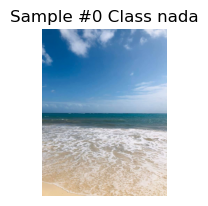

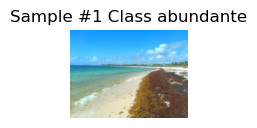

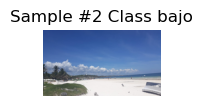

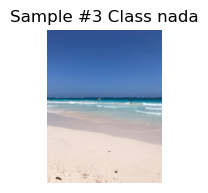

In [33]:
fig = plt.figure()

for i in range(len(full_dataset)):
    sample = training_dataset[i]
    image, label = sample
    
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{} Class {}'.format(i, id2class[label]))
    ax.axis('off')
    show_image(image, label)

    if i == 3:
        plt.show()
        break

## Descenso por gradiente

Implementación del descenso por gradiente.

In [34]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs = 25, is_inception= False, save_after = 100):
    since = time.time()
    
    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    #print(device)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))
        
        #Each epoch as a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in iter(dataloaders[phase]):
                #print(inputs)
                #print(labels)
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                #zero the parameter gradients
                optimizer.zero_grad()
                
                #forward
                # track history
                with torch.set_grad_enabled(phase == 'train'):
                    
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                        
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        
                    _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss /len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), wts_str + '_best.pt')
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
            
            if phase == 'train' and epoch % save_after == 0 :
                torch.save(model.state_dict(), wts_str + '_epoch' + str(epoch) + '.pt')
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    #load the best model
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, val_loss_history, train_loss_history

In [35]:
# set model parameters
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            # Freeze parameters
            param.requires_grad = False

## Crear modelo de red neuronal

In [36]:
# Initialize and reshape the networks
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG16
        """
        model_ft = models.vgg16(pretrained=use_pretrained)
        model_ft = models.vgg16(weights='IMAGENET1K_V1')
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=pretrained)

# Print the model we just instantiated
print(model_ft)

model_ft.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Entrenamiento

In [37]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [38]:
# configure paths to the description txt file and the images folder
images_path = '../input/sargazo-dataset/sargazo_dataset/images'

# Create training and validation datasets
image_datasets = {'train': SargazoDataset(train_df, img_folder, data_transforms['train']), 'val': SargazoDataset(valid_df, img_folder, data_transforms['val'])}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [39]:
# create the optimizer
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn")

if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t", name)
            
optimizer_ft = optim.SGD(params_to_update, lr=learning_rate,momentum=0.9)
criterion = nn.CrossEntropyLoss()

Params to learn
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.bn

In [40]:
#model_ft.load_state_dict(torch.load('w_vgg_pret_True_feat_False_lr_0.001_best.pt'))

In [41]:
# Execute full training
if run_training:
    model_ft, hist, hist_t,loss_hist,loss_hist_t = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs = epochs, is_inception=(model_name=="inception"))

Epoch 0/24
train Loss: 1.2797 Acc: 0.5326
val Loss: 1.0517 Acc: 0.5533

Epoch 1/24
train Loss: 1.0038 Acc: 0.6028
val Loss: 0.9166 Acc: 0.6400

Epoch 2/24
train Loss: 0.9170 Acc: 0.6421
val Loss: 0.8278 Acc: 0.6800

Epoch 3/24
train Loss: 0.8709 Acc: 0.6689
val Loss: 0.8736 Acc: 0.6567

Epoch 4/24
train Loss: 0.8028 Acc: 0.6831
val Loss: 0.7800 Acc: 0.6700

Epoch 5/24
train Loss: 0.7558 Acc: 0.7032
val Loss: 0.8044 Acc: 0.6733

Epoch 6/24
train Loss: 0.7364 Acc: 0.7107
val Loss: 0.7906 Acc: 0.6933

Epoch 7/24
train Loss: 0.6949 Acc: 0.7283
val Loss: 0.8214 Acc: 0.6700

Epoch 8/24
train Loss: 0.6669 Acc: 0.7366
val Loss: 0.8205 Acc: 0.6900

Epoch 9/24
train Loss: 0.6246 Acc: 0.7617
val Loss: 0.7924 Acc: 0.6733

Epoch 10/24
train Loss: 0.6286 Acc: 0.7550
val Loss: 0.9030 Acc: 0.6667

Epoch 11/24
train Loss: 0.5648 Acc: 0.7826
val Loss: 0.8422 Acc: 0.6767

Epoch 12/24
train Loss: 0.5704 Acc: 0.7784
val Loss: 0.9271 Acc: 0.6933

Epoch 13/24
train Loss: 0.5265 Acc: 0.8077
val Loss: 0.8256 A

In [42]:
if save_weights:
    torch.save(model_ft.state_dict(), wts_str)

## Graficar resultados

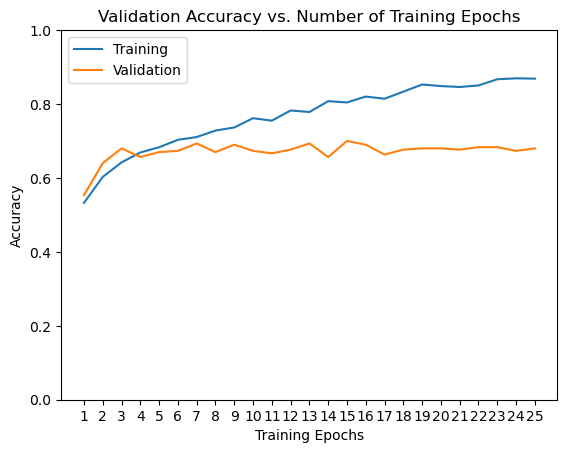

In [43]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
vhist = []
thist = []

vhist = [h.cpu().numpy() for h in hist]
thist = [h.cpu().numpy() for h in hist_t]
#shist = [h.cpu().numpy() for h in scratch_hist]

np.save('val_history', vhist)
np.save('train_history', vhist)

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,epochs+1),thist,label="Training")
plt.plot(range(1,epochs+1),vhist,label="Validation")
plt.ylim((0,1.))
plt.xticks(np.arange(1, epochs+1, 1.0))
plt.legend()
file_name = wts_str + '_acc.png'
plt.savefig(file_name)
plt.show()

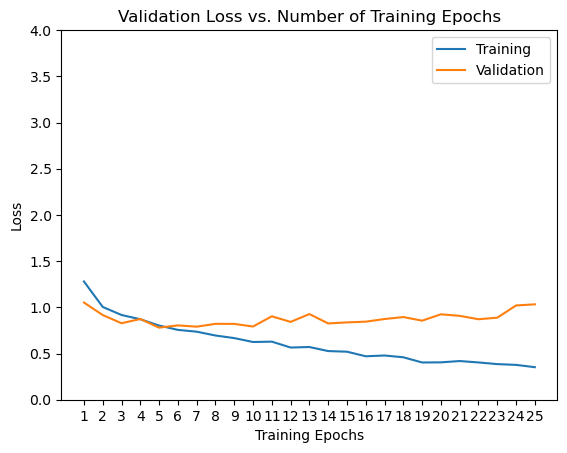

In [44]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
vhist_loss = np.array(loss_hist)
thist_loss = np.array(loss_hist_t)

np.save('val_history', vhist_loss)
np.save('train_history', thist_loss)

plt.title("Validation Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1,epochs+1),thist_loss,label="Training")
plt.plot(range(1,epochs+1),vhist_loss,label="Validation")
plt.ylim((0,4.))
plt.xticks(np.arange(1, epochs+1, 1.0))
plt.legend()
file_name = wts_str + '_loss.png'
plt.savefig(file_name)
plt.show()

In [45]:
def test_model(model, dataloaders):
    print("Evaluating model")
    print(time.time())
            
    # Iterate over data
    it = 0
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
                
        model.train(False)
        model.eval()
                    
        outputs = model(inputs)
                        
        _, preds = torch.max(outputs, 1)
        
        np_pred_labels = preds.cpu().numpy()
        np_real_labels = labels.cpu().numpy()
        if it == 0:
            pred_labels = np_pred_labels
            real_labels = np_real_labels
        else:
            pred_labels = np.concatenate((pred_labels,np_pred_labels))
            real_labels = np.concatenate((real_labels,np_real_labels))
        it= it+1
        
        del inputs
        del labels
        torch.cuda.empty_cache()
    
    print(time.time())
    return pred_labels,real_labels

In [46]:
predict_labels,actual_labels = test_model(model_ft, dataloaders_dict)

Evaluating model
1687823393.7272463
1687823399.0861337


In [47]:
from sklearn.metrics import classification_report
print(classification_report(actual_labels,predict_labels))

              precision    recall  f1-score   support

           0       0.79      0.91      0.85       174
           1       0.53      0.33      0.41        69
           2       0.44      0.39      0.41        31
           3       0.44      0.57      0.50        14
           4       0.69      0.75      0.72        12

    accuracy                           0.70       300
   macro avg       0.58      0.59      0.58       300
weighted avg       0.68      0.70      0.68       300



In [48]:
df_confusion = pd.crosstab(actual_labels, predict_labels,rownames=["True label"],colnames=["Predicted label"])
print(df_confusion)
df_confusion.rename(columns=id2class,index=id2class,inplace=True)
print(df_confusion)
df_confusion.to_csv('cm_exp5.csv')

Predicted label    0   1   2  3  4
True label                        
0                158  13   2  1  0
1                 33  23  10  2  1
2                  7   6  12  5  1
3                  1   1   2  8  2
4                  0   0   1  2  9
Predicted label  nada  bajo  moderado  abundante  excesivo
True label                                                
nada              158    13         2          1         0
bajo               33    23        10          2         1
moderado            7     6        12          5         1
abundante           1     1         2          8         2
excesivo            0     0         1          2         9


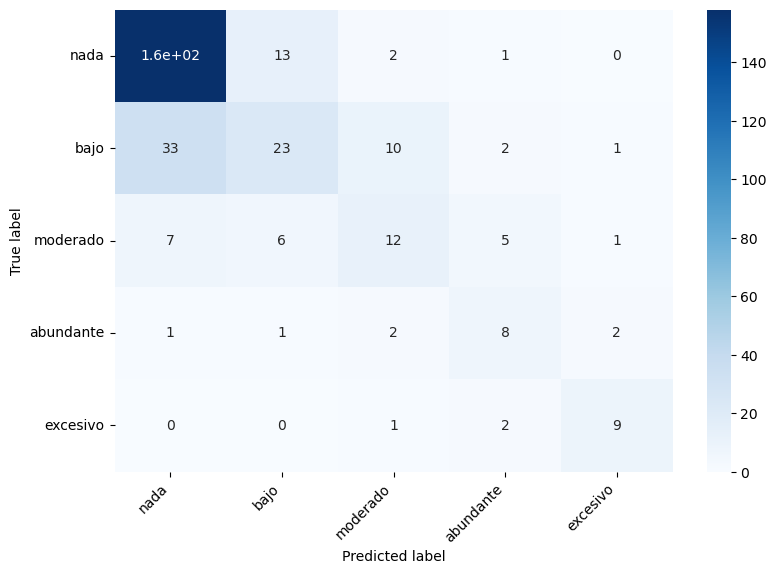

In [49]:
f, ax = plt.subplots(figsize=(9,6))

parameters = {'axes.labelsize': 10}
plt.rcParams.update(parameters)

g = sn.heatmap(df_confusion, annot = True, cmap = 'Blues',ax=ax)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_yticklabels(g.get_yticklabels(), rotation=0, horizontalalignment='right')

plt.savefig("CM_exp5.eps",format = "eps",bbox_inches='tight')
plt.show()

In [50]:
df_norm_col= round(df_confusion.div(df_confusion.sum(axis=1),axis=0),2) 
print(df_norm_col)

Predicted label  nada  bajo  moderado  abundante  excesivo
True label                                                
nada             0.91  0.07      0.01       0.01      0.00
bajo             0.48  0.33      0.14       0.03      0.01
moderado         0.23  0.19      0.39       0.16      0.03
abundante        0.07  0.07      0.14       0.57      0.14
excesivo         0.00  0.00      0.08       0.17      0.75


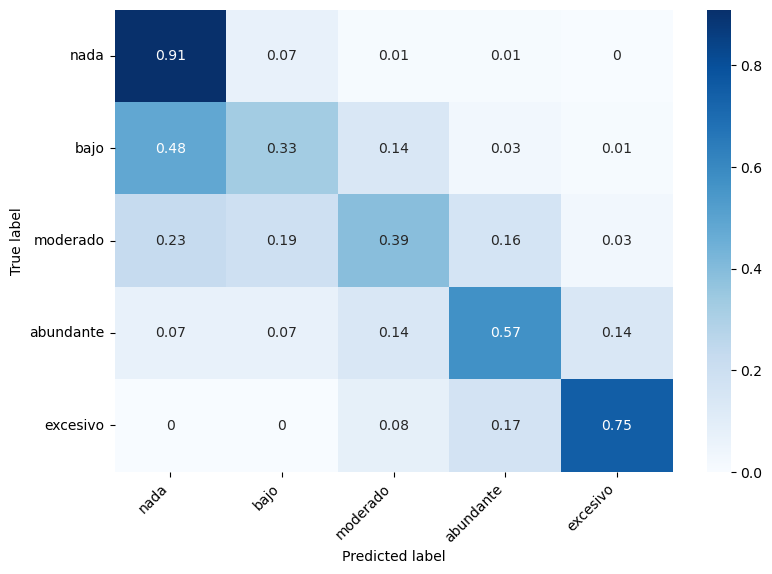

In [51]:
f, ax = plt.subplots(figsize=(9,6))

parameters = {'axes.labelsize': 10}
plt.rcParams.update(parameters)

g = sn.heatmap(df_norm_col, annot = True, cmap = 'Blues')
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_yticklabels(g.get_yticklabels(), rotation=0, horizontalalignment='right')

plt.savefig("CM_exp5_norm.eps",format = "eps",bbox_inches='tight')
plt.show()

## Inferencia para el challenge

In [52]:
test_file = '/kaggle/input/publicsargazods/labels/test.csv'

In [53]:
test_df = pd.read_csv(test_file) 
test_df.sample(5)


,Unnamed: 0,image_name,place,date
42,1428,s0731.jpg,Diamante K,22/09/2019
160,0,k0005.jpg,desconocido,desconocido
154,1271,s0568.jpg,Xcacel,08/06/2019
72,396,k0470.jpg,desconocido,desconocido
49,706,k0855.jpg,desconocido,desconocido


In [54]:
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

    
model_ft.eval()
test_predictions = []
for file in test_df['image_name']:
    
    # cuidado si cambia la tabla se debe de cambiar esto
    image_path = os.path.join(img_folder, file)
    #print(image_path)
    
    image = pil_loader(image_path)
    img_transf = data_transforms['val'](image)
    img_transf = img_transf.unsqueeze(0)
    #print(img_transf.shape)
    
    #print(labels)
    img_transf = img_transf.to(device)
                       
    outputs = model_ft(img_transf)
    #print(outputs)                    
    _, preds = torch.max(outputs, 1)
    test_predictions.append(id2class[preds.cpu().numpy()[0]])
    
#print(test_predictions)
temp = {'image_name': test_df['image_name'], 'label': test_predictions}
output_df = pd.DataFrame(data=temp)
output_df.sample(10)

output_df.to_csv('output.csv')